In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm

import torch
import torch.nn as nn
# import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [2]:
data_train = pd.read_csv('data_train_test.csv')

In [3]:
data_train.keys()

Index(['patient_id', 'patient_nhd', 'patient_ds', 'rec_date_time', 'abs',
       'std', 'norm_abs', 'mean', 'sd', 'median', 'mode', 'Q25', 'Q75', 'IQR',
       'skew', 'kurt', 'kx2', 'n_pic', 'patient_manual_class'],
      dtype='object')

In [4]:
# data_train.dropna()[['patient_id', 'patient_manual_class', 'abs', 'std', 'norm_abs', 'mean', 'sd',
#        'median', 'mode', 'Q25', 'Q75', 'IQR', 'skew', 'kurt', 'kx2', 'n_pic']]
data_train.dropna()[['patient_nhd']]

,patient_nhd
7,1963.0
8,7.0
9,7.0
12,48.0
14,17.0
...,...
642,24.0
643,13.0
644,13.0
645,10.0


In [5]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
device

device(type='cpu')

In [6]:
np.array(data_train.dropna()[['patient_id', 'abs', 'std', 'norm_abs', 'mean', 'sd',
                                                'median', 'mode', 'Q25', 'Q75', 'IQR', 'skew', 'kurt', 'kx2', 'n_pic','patient_manual_class']])

array([[8.00000000e+00, 4.77020012e+02, 6.51304517e+02, ...,
        2.80000000e+01, 1.30000000e+01, 0.00000000e+00],
       [9.00000000e+00, 4.08186401e+03, 5.40835923e+03, ...,
        5.95800000e+03, 1.50000000e+01, 1.00000000e+00],
       [9.00000000e+00, 3.71956882e+03, 4.88753120e+03, ...,
        6.50000000e+03, 1.40000000e+01, 1.00000000e+00],
       ...,
       [4.70000000e+01, 2.23553232e+03, 3.02401008e+03, ...,
        1.86900000e+03, 1.70000000e+01, 1.00000000e+00],
       [2.50000000e+01, 4.30080886e+03, 5.57165490e+03, ...,
        5.16600000e+03, 1.20000000e+01, 1.00000000e+00],
       [1.70000000e+01, 1.92078969e+03, 2.52735033e+03, ...,
        1.38900000e+03, 8.00000000e+00, 2.00000000e+00]])

In [7]:
class MyCustomDataset(Dataset):
    def __init__(self, my_device=torch.device('cpu')):
        data_train = pd.read_csv('data_train_test.csv')
        data_train.dropna()

        x_train = np.array(data_train.dropna()[['patient_id', 'patient_nhd', 'abs', 'std', 'norm_abs', 'mean', 'sd',
                                                'median', 'mode', 'Q25', 'Q75', 'IQR', 'skew', 'kurt', 'kx2', 'n_pic']])
        y_train = np.array(data_train.dropna()[['patient_manual_class']])

        # data_test = pd.read_csv('data_test.csv')
        # data_test.dropna()

        # x_test = [np.random.randint(0, 9, size=(5)) for _ in range(51_200)]
        # y_test = [np.array([np.sum(l)/2, np.sum(l) / len(l)]) for l in x_train]

        self.lenght = len(x_train)

        my_dtype = torch.float32

        self.torch_train = [[torch.tensor(x_train[i], dtype=my_dtype, requires_grad=True, device=my_device),
                             torch.tensor(y_train[i], dtype=my_dtype, requires_grad=True, device=my_device)] for i in range(self.lenght)]
        # self.torch_train = [[torch.tensor(x_train[i], dtype=my_dtype, requires_grad=True),
        #                      torch.tensor(y_train[i], dtype=my_dtype, requires_grad=True)] for i in range(self.lenght)]

    def __getitem__(self, index):
        return self.torch_train[index][0], self.torch_train[index][1]

    def __len__(self):
        return self.lenght

In [8]:
batch_size = 8
my_dataset = DataLoader(dataset=MyCustomDataset(my_device=device), batch_size=batch_size, shuffle=True)

In [9]:
class Net(nn.Module): 
    # Объявить слой с параметрами модели
    def __init__(self):
        # Вызвать конструктор родительского класса Net для выполнения необходимой инициализации. 
        super().__init__()  
        self.relu = nn.ReLU() 
        #self.sigmoid = nn.Sigmoid() 
        self.layer_1 = nn.Linear(16, 16) 
        self.layer_2 = nn.Linear(16, 1) 
        self.softmax = nn.Softmax(dim=1)

    # Определить предварительный расчет модели, то есть, как вернуть требуемый выход модели в соответствии с расчетом входных x
    def forward(self, x): 
        x = self.relu(self.layer_1(x)) 
        x = self.softmax(self.layer_2(x)) 
        return x

In [10]:
model = Net()

In [11]:
model.train(True)

Net(
  (relu): ReLU()
  (layer_1): Linear(in_features=16, out_features=16, bias=True)
  (layer_2): Linear(in_features=16, out_features=1, bias=True)
  (softmax): Softmax(dim=1)
)

In [12]:
model.to(device=device)

Net(
  (relu): ReLU()
  (layer_1): Linear(in_features=16, out_features=16, bias=True)
  (layer_2): Linear(in_features=16, out_features=1, bias=True)
  (softmax): Softmax(dim=1)
)

In [13]:
loss_array = []
epoch = 0

class TqdmExtraFormat(tqdm):
    @property
    def format_dict(self):
        d = super(TqdmExtraFormat, self).format_dict

        if len(loss_array) > 1:
            E = np.mean(loss_array[-1000:])
        else:
            E = 0

        d.update(loss = np.round(E, 4))
        d.update(epoch = epoch)
        return d

In [14]:
optimizer = torch.optim.Adam(model.parameters())

# loss_fn = nn.CrossEntropyLoss()
loss_fn = nn.MSELoss()

num_epochs = 10

In [15]:
for epoch in range(num_epochs):
    for data in TqdmExtraFormat(iterable=my_dataset, bar_format="Epoch {epoch}: {l_bar}{bar}{r_bar} loss={loss}"):
        # x = data[0].to(device)
        # target = data[1].to(device)

        x = data[0]
        target = data[1]

        optimizer.zero_grad()

        prediction = model.forward(x)

        loss = loss_fn(prediction, target)
        loss.backward()

        loss_array.append(float(loss))
        # if len(loss_array) > 1000:
        #     del loss_array[0]

        optimizer.step()

Epoch 0:   0%|                                   | 0/57 [00:00<?, ?it/s] loss=0C:\Users\Chernyavskaya_OS\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\autograd\__init__.py:200: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 9010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ..\c10\cuda\CUDAFunctions.cpp:109.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
Epoch 9: 100%|████████████████████| 57/57 [00:00<00:00, 422.24it/s] loss=0.2086


In [16]:
i = 6
#print(y := my_dataset.dataset[i][1])
#print(z := model.forward(my_dataset.dataset[i][0].to(device)))

tensor([1.], requires_grad=True)


IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

In [17]:
my_dataset.dataset[i][0]

tensor([1.8000e+01, 3.0000e+00, 1.4500e+03, 1.8837e+03, 1.4614e-01, 1.4870e+02,
        1.5770e+02, 1.0643e+02, 9.5905e+01, 7.5365e+01, 1.6481e+02, 8.9444e+01,
        5.4352e+00, 3.9540e+01, 2.2790e+03, 1.0000e+01], requires_grad=True)

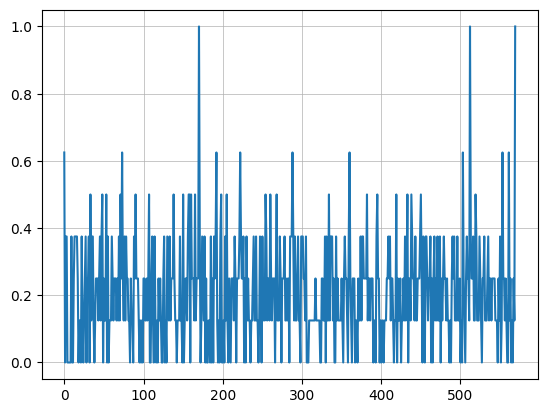

In [18]:
slice_loss_array = loss_array

X_func = np.arange(0, len(slice_loss_array), 1)

# plt.xticks(np.arange(0, len(slice_loss_array), step=1000))
# plt.yticks(np.arange(0, int(max(slice_loss_array)) + 2, step=200_000))
plt.grid(linestyle='-', linewidth=0.5)

plt.plot(X_func, slice_loss_array)
plt.show()

In [19]:
model.forward(x)

tensor([[1.]], grad_fn=<SoftmaxBackward0>)

In [20]:
# import csv
# with open('data_2.csv', 'w') as f:
#     fieldnames = ['patient_id','patient_nhd','patient_ds,','patient_manual_class','rec_date_time','abs','std','norm_abs','mean','sd','median','mode','Q25','Q75','IQR','skew','kx2','n_pic','fistulas_kind']
#     writer = csv.DictWriter(f, fieldnames=fieldnames, lineterminator = '\\n')
#     #writer.writeheader()
#     with torch.no_grad():
#         for x in train_loader:
#             x = x.to(device).float()
#             output = model(x).argmax(dim=1)
#             for y in output:
#                 writer.writerow({fieldnames[18]: y.item()})